Episode 100, Reward: 83.65, Win Rate: 2.0%, Steps: 19.2
Episode 200, Reward: 84.54, Win Rate: 6.0%, Steps: 18.6
Episode 300, Reward: 81.94, Win Rate: 0.0%, Steps: 19.1
Episode 400, Reward: 86.79, Win Rate: 6.0%, Steps: 19.4
Episode 500, Reward: 85.09, Win Rate: 7.0%, Steps: 19.3
Episode 600, Reward: 92.19, Win Rate: 14.0%, Steps: 18.9
Episode 700, Reward: 84.73, Win Rate: 5.0%, Steps: 19.3
Episode 800, Reward: 90.66, Win Rate: 14.0%, Steps: 19.4
Episode 900, Reward: 89.15, Win Rate: 10.0%, Steps: 18.8
Episode 1000, Reward: 93.46, Win Rate: 18.0%, Steps: 19.1
Episode 1100, Reward: 96.39, Win Rate: 20.0%, Steps: 18.8
Episode 1200, Reward: 99.91, Win Rate: 22.0%, Steps: 18.9
Episode 1300, Reward: 94.58, Win Rate: 21.0%, Steps: 19.0
Episode 1400, Reward: 102.41, Win Rate: 28.0%, Steps: 18.8
Episode 1500, Reward: 104.41, Win Rate: 34.0%, Steps: 19.1
Episode 1600, Reward: 104.59, Win Rate: 32.0%, Steps: 19.1
Episode 1700, Reward: 98.13, Win Rate: 26.0%, Steps: 19.1
Episode 1800, Reward: 105.

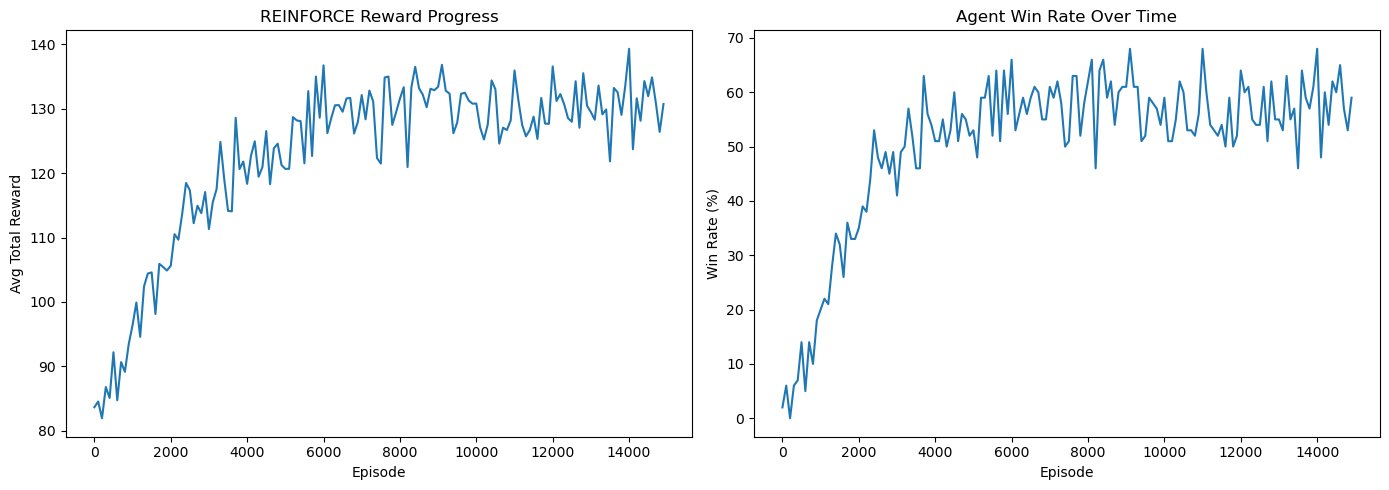

✅ Evaluation: 62/100 correct guesses → Win Rate: 62.0%


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from transformers import T5ForConditionalGeneration, T5Tokenizer

# --- Load Data ---
df = pd.read_excel('knowledge_base1.xlsx')
FEATURES = ["Hair", "Feathers", "Eggs", "Milk", "Airborne", "Aquatic", "Predator", "Toothed",
            "Backbone", "Breathes", "Venomous", "Fins", "Nlegs_0", "Nlegs_2", "Nlegs_4",
            "Nlegs_5", "Nlegs_6", "Nlegs_8", "Tail", "Domestic", "Catsize",
            "Mammal", "Bird", "Reptile", "Fish", "Amphibian", "Insect", "Invertebrate"]
NUM_ANIMALS = 100
NUM_FEATURES = len(FEATURES)
MAX_STEPS = 20

animal_names = df.iloc[:, 0].values
animal_features = df.iloc[:, 1:].values.astype(np.float32)

# --- T5-small Question Generator ---
t5_model = T5ForConditionalGeneration.from_pretrained("t5-small")
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")

def generate_question(feature):
    prompt = f"Generate a yes/no question about: {feature}"
    input_ids = t5_tokenizer(prompt, return_tensors="pt").input_ids
    output_ids = t5_model.generate(input_ids, max_length=16)
    return t5_tokenizer.decode(output_ids[0], skip_special_tokens=True)

# --- Policy Network ---
class PolicyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(NUM_FEATURES, 128)
        self.fc2 = nn.Linear(128, NUM_FEATURES)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=-1)

# --- Guesser Network ---
class Guesser(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.log_softmax(self.fc2(x), dim=-1)

# --- Helper to Filter Animals ---
def filter_animals(candidates, state):
    mask = np.ones(len(candidates), dtype=bool)
    for i, val in enumerate(state):
        if val != 0:
            mask = mask & (animal_features[candidates, i] == val.item())
    return candidates[mask]

# --- Main Components ---
policy = PolicyNetwork()
guesser = Guesser(NUM_FEATURES, NUM_ANIMALS)
optimizer = optim.Adam(list(policy.parameters()) + list(guesser.parameters()), lr=1e-3)

# --- Training Episode ---
def play_episode():
    target_idx = random.randint(0, NUM_ANIMALS - 1)
    target_features = animal_features[target_idx]

    state = torch.zeros(NUM_FEATURES)
    log_probs = []
    entropies = []
    asked = set()
    steps = 0

    remaining = np.arange(NUM_ANIMALS)
    total_reward = 0.0

    for _ in range(MAX_STEPS):
        steps += 1
        probs = policy(state)
        mask = torch.ones_like(probs)
        mask[list(asked)] = 0
        masked_probs = probs * mask
        masked_probs = masked_probs / masked_probs.sum()

        dist = torch.distributions.Categorical(masked_probs)
        action = dist.sample()
        feature_idx = action.item()
        log_probs.append(dist.log_prob(action))
        entropies.append(dist.entropy())

        if feature_idx in asked:
            total_reward -= 5.0
        else:
            asked.add(feature_idx)

        new_state = state.clone().detach()
        new_state[feature_idx] = float(target_features[feature_idx])
        state = new_state

        prev_count = len(remaining)
        remaining = filter_animals(remaining, state)
        eliminated = prev_count - len(remaining)
        total_reward += eliminated

        if eliminated >= 10:
            total_reward += 10.0

        if len(remaining) <= 1:
            break

    guess_logits = guesser(state)
    predicted_idx = torch.argmax(guess_logits).item()
    final_reward = 30.0 if predicted_idx == target_idx else -30.0
    total_reward += final_reward

    entropy_sum = torch.stack(entropies).sum()
    guess_loss = F.nll_loss(guess_logits.unsqueeze(0), torch.tensor([target_idx]))

    return log_probs, total_reward, entropy_sum, final_reward, guess_loss, steps

# --- Training Function ---
def train(num_episodes=15000):
    rewards, win_flags, steps_list = [], [], []
    avg_rewards, win_rates, avg_steps = [], [], []

    for episode in range(num_episodes):
        log_probs, reward, entropy, final_reward, guess_loss, steps = play_episode()

        baseline = np.mean(rewards[-100:]) if len(rewards) >= 100 else 0
        advantage = reward - baseline
        reinforce_loss = -sum(log_probs) * advantage - 0.01 * entropy
        loss = reinforce_loss + guess_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        rewards.append(reward)
        win_flags.append(1 if final_reward > 0 else 0)
        steps_list.append(steps)

        if (episode + 1) % 100 == 0:
            avg_rewards.append(np.mean(rewards[-100:]))
            win_rates.append(np.mean(win_flags[-100:]))
            avg_steps.append(np.mean(steps_list[-100:]))

            print(f"Episode {episode+1}, Reward: {avg_rewards[-1]:.2f}, Win Rate: {win_rates[-1]*100:.1f}%, Steps: {avg_steps[-1]:.1f}")

    # Plotting
    episodes = np.arange(len(avg_rewards)) * 100
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(episodes, avg_rewards)
    plt.title("REINFORCE Reward Progress")
    plt.xlabel("Episode")
    plt.ylabel("Avg Total Reward")

    plt.subplot(1, 2, 2)
    plt.plot(episodes, [w * 100 for w in win_rates])
    plt.title("Agent Win Rate Over Time")
    plt.xlabel("Episode")
    plt.ylabel("Win Rate (%)")

    plt.tight_layout()
    plt.show()

# --- Evaluation ---
def evaluate(num_games=100):
    wins = 0
    for _ in range(num_games):
        target_idx = random.randint(0, NUM_ANIMALS - 1)
        target_features = animal_features[target_idx]
        state = torch.zeros(NUM_FEATURES)
        asked = set()

        for _ in range(MAX_STEPS):
            probs = policy(state)
            mask = torch.ones_like(probs)
            mask[list(asked)] = 0
            masked_probs = probs * mask
            masked_probs = masked_probs / masked_probs.sum()

            action = torch.argmax(masked_probs).item()
            asked.add(action)
            state[action] = float(target_features[action])

        guess_logits = guesser(state)
        predicted_idx = torch.argmax(guess_logits).item()
        if predicted_idx == target_idx:
            wins += 1

    print(f"✅ Evaluation: {wins}/{num_games} correct guesses → Win Rate: {wins/num_games*100:.1f}%")

# Train and evaluate
train(num_episodes=15000)
evaluate(num_games=100)


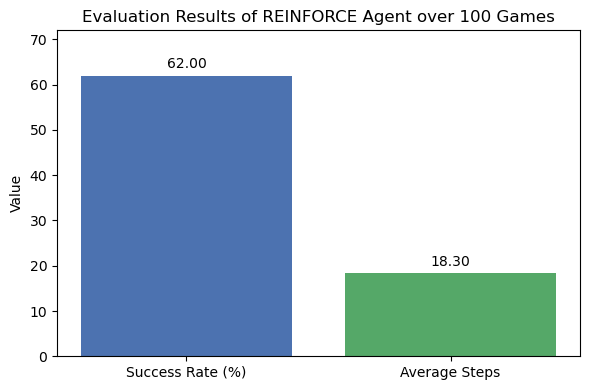

In [10]:
# Re-import required modules after kernel reset
import matplotlib.pyplot as plt

# Evaluation data
metrics = ['Success Rate (%)', 'Average Steps']
values = [62.00, 18.3]

# Create the plot with custom colors
plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['#4C72B0', '#55A868'])  # Blue and green

plt.title("Evaluation Results of REINFORCE Agent over 100 Games")
plt.ylabel("Value")
plt.ylim(0, max(values) + 10)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()

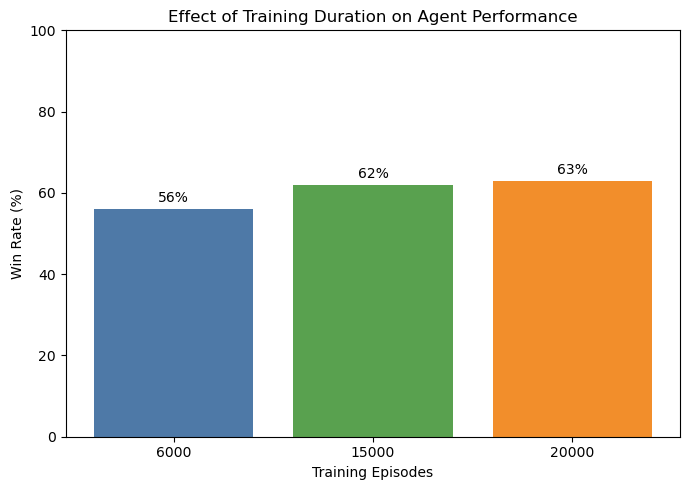

In [12]:
import matplotlib.pyplot as plt

episodes = [6000, 15000, 20000]
win_rates = [56, 62, 63]

plt.figure(figsize=(7, 5))
bars = plt.bar([str(e) for e in episodes], win_rates, color=['#4e79a7', '#59a14f', '#f28e2b'])

# Annotate win rate values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.0f}%', ha='center', va='bottom', fontsize=10)

plt.title("Effect of Training Duration on Agent Performance")
plt.xlabel("Training Episodes")
plt.ylabel("Win Rate (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

